### Final Project Code Base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

from torchvision.datasets.utils import download_url, check_integrity

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import glob
import cv2
import torch
import torchvision.utils as vutils
import torchvision.models as models
import torch.optim as optim
import scipy.io
from torch.utils.data import Dataset
from torchvision import transforms

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


IS_GPU = True
TEST_BS = 2
TRAIN_BS = 4
dataroot='/content/drive/MyDrive/585_data/alt_images/'
# dataroot='/content/drive/MyDrive/585_data/'

train_transform = transforms.Compose(
    [
     transforms.CenterCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[0.46447453, 0.42939538, 0.39643392], std=[0.27552935, 0.26626697, 0.27488974])
     ])

test_transform = transforms.Compose(
    [
     transforms.CenterCrop((224,224)),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# ---------------------


class GANDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        self.img_folder = os.path.join(self.root_dir, "images/", self.split)
        self.gt_folder = os.path.join(self.root_dir, "ground_truth/", self.split)

    
        self.img_filenames = sorted(os.listdir(self.img_folder))
        self.gt_filenames = sorted(os.listdir(self.gt_folder))

    def __len__(self):
        return len(self.img_filenames)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_filenames[idx])
        gt_path = os.path.join(self.gt_folder, self.gt_filenames[idx])
        
        img = Image.open(img_path)
        gt = Image.open(gt_path).convert('RGB')
       
        
        if self.transform:
            img = self.transform(img)
            gt=self.transform(gt)
        
        return img, gt

dataset=GANDataset(dataroot,split='train',transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=TRAIN_BS,
                                         shuffle=True, num_workers=0)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

val_dataset=GANDataset(dataroot,split='val',transform=train_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS,
                                         shuffle=True, num_workers=0)


In [ ]:
#from  https://github.com/captanlevi/Contour-Detection-Pytorch/blob/master/net.py
class Encoder(nn.Module):
    def __init__(self, vgg):
        super().__init__()
        self.vgg = list(vgg.children())
        self.vgg=self.vgg[0]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.conv6 = nn.Conv2d(in_channels = 512, out_channels = 4096, kernel_size = 3, stride=1, padding = 1)
        
    def forward(self,x):

        pooling_info = {}
        layer_info = {}
        # Starting conv1
        x = self.vgg[0](x)
 
        x = self.vgg[1](x)
        x = self.vgg[2](x)
        x = self.vgg[3](x)
        shape = x.shape
        
        layer_info[1] = {"value": x}
        x , ind = self.pool1(x)
        pooling_info[1] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
        

        # start conv2
        x = self.vgg[5](x)
        x = self.vgg[6](x)
        x = self.vgg[7](x)
        x = self.vgg[8](x)

        shape = x.shape
        layer_info[2] = {"value": x}
        x , ind = self.pool2(x)
        pooling_info[2] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}


        # start conv3
        x = self.vgg[10](x)
        x = self.vgg[11](x)
        x = self.vgg[12](x)
        x = self.vgg[13](x)
        x = self.vgg[14](x)
        x = self.vgg[15](x)

        shape = x.shape
        layer_info[3] = {"value": x}
        x , ind = self.pool3(x)
        pooling_info[3] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
  

        x = self.vgg[17](x)
        x = self.vgg[18](x)
        x = self.vgg[19](x)
        x = self.vgg[20](x)
        x = self.vgg[21](x)
        x = self.vgg[22](x)

        shape = x.shape
        layer_info[4] = {"value": x}
        x , ind = self.pool4(x)
        pooling_info[4] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
      

        x = self.vgg[24](x)
        x = self.vgg[25](x)
        x = self.vgg[26](x)
        x = self.vgg[27](x)
        x = self.vgg[28](x)
        x = self.vgg[29](x)

        shape = x.shape
        layer_info[5] = {"value": x}
        x , ind = self.pool5(x)
        pooling_info[5] = {"kernel_size" : 2, "stride": 2, "padding": 0 ,"output_size": shape,"indices":ind}
    
        x = self.conv6(x)

        
        return x , pooling_info, layer_info
         

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dconv6 = nn.Conv2d(in_channels = 4096, out_channels = 512, kernel_size = 1, stride=1)
       
        self.deconv5 = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding =2)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 5 , padding = 2)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 5 ,padding = 2)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 5 , padding = 2)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 5 ,padding = 2)
        self.pred = nn.ConvTranspose2d(in_channels = 32, out_channels =3, kernel_size = 5, padding = 2)

    def forward(self,encoder_out):
        x = encoder_out[0]
        dicts = encoder_out[1]

        x = self.dconv6(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[5])

        
     
        x = self.deconv5(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[4])  # Indices 512

        x = self.deconv4(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[3])  # Indices 256

        x = self.deconv3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[2])  # Indices 128

        x = self.deconv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_unpool2d(x, **dicts[1])  # Indices 64
        x = self.deconv1(x)
        x = nn.functional.relu(x)

        x = self.pred(x)

        x = torch.sigmoid(x)
        return x
    
class countour_detector(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder = Encoder(backbone.to(device)).to(device)
        self.decoder = Decoder().to(device)

    def forward(self,x):
        x = self.encoder(x)
        return self.decoder(x)
    
# adapted from https://github.com/ylf-li/ContourGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # self.conv3 = nn.Conv2d(128, 256, kernel_size=3,stride=2, padding=1)
        # self.bn3 = nn.BatchNorm2d(256)
        # self.conv4 = nn.Conv2d(256, 512, kernel_size=3,stride=2, padding=1)
        # self.bn4 = nn.BatchNorm2d(512)
        # self.conv5 = nn.Conv2d(512, 512, kernel_size=3,stride=2, padding=1)
        # self.bn5 = nn.BatchNorm2d(512)
        # self.conv6 = nn.Conv2d(512, 512, kernel_size=3,stride=2, padding=1)
        # self.bn6 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc3 = nn.Linear(100, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        # x = self.lrelu(self.bn3(self.conv3(x)))
        # x = self.lrelu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        # x = self.lrelu(self.bn5(self.conv5(x)))
        # x = self.lrelu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        # x = self.lrelu(self.bn7(self.conv7(x)))
        # x = self.lrelu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.lrelu(self.fc1(x))
        x = self.lrelu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

vgg16 =  torchvision.models.vgg16(pretrained=True).to(device)

for p in vgg16.parameters():
    p.requires_grad = False

net = countour_detector(backbone=vgg16).to(device)
print(net)

# net = Discriminator().to(device)
# dummy_input = torch.rand((1,3,224,224)).to(device)
# output = net(dummy_input)
# print(net)
# # for p in net.parameters():
# #   # print(p)
# #   print(p.requires_grad)

# # # Test your BaseNet with some random input
# dummy_input = torch.rand((1,3,224,224)).to(device)
# output = net(dummy_input)
# print(output.shape)





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]


countour_detector(
  (encoder): Encoder(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [ ]:
#loss from https://github.com/captanlevi/Contour-Detection-Pytorch/blob/master/net.py
def context_loss(outputs, targets):
        weights = torch.empty_like(targets).to(device)
        weights[targets >= .98] = 10
        weights[targets < .98] = 1
        loss = F.binary_cross_entropy(outputs, targets, weights)
        return loss 


In [ ]:
#from PS2 template
generator = countour_detector(backbone=vgg16).to(device)
discriminator = Discriminator().to(device)

lr = 1e-4

g_optimizer = torch.optim.Adam([x for x in list(generator.parameters()) if x.requires_grad == True], lr=lr,weight_decay=1e-5)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr,weight_decay=1e-5)

gan_loss = nn.BCELoss().to(device)

num_epochs = 15

best_loss = float('inf')
best_model_state_dict = None

for epoch in range(num_epochs):
  for batch_idx, (real_samples, labels) in enumerate(dataloader):
        real_samples=real_samples.to(device)
        labels=labels.to(device)
        # noise = generate_noise([TRAIN_BS,3,224,224]).to(device)
        real_output=generator(real_samples)
        real_prediction=discriminator(real_output)
        # print(real_prediction)
        # fake_output = generator(noise)
        # fake_prediction=discriminator(fake_output)
        GT_prediction=discriminator(labels)

        # Train the discriminator
        discriminator.zero_grad()
        d_real_loss = gan_loss(GT_prediction, torch.ones_like(GT_prediction))
        d_fake_loss = gan_loss(real_prediction, torch.zeros_like(real_prediction))
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward(retain_graph=True)
        d_optimizer.step()

        # # Train the generator
        generator.zero_grad()
        g_gan_loss = gan_loss(real_prediction, torch.ones_like(real_prediction))
        loss_context = context_loss(real_output,labels)
        loss_context = torch.mean(loss_context)
        g_loss = (g_gan_loss*.01) + loss_context
        g_loss.backward()
        g_optimizer.step()

        if batch_idx % 10==0:
          print("Epoch [{}/{}], Batch [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}".format(epoch+1, num_epochs, batch_idx+1, len(dataloader), d_loss.item(), g_loss.item()))

        if batch_idx % 200==0:
          with torch.no_grad():
                val_loss = 0
                for batch_idx, (data, target) in enumerate(val_dataloader):
                    # print(len(val_dataloader))
                    data=data.to(device)
                    target=target.to(device)
                    output = generator(data)
                    val_loss += context_loss(output, target)
                  
                val_loss /= len(val_dataloader)
                print(val_loss)
                if val_loss < best_loss:
                      best_loss = val_loss
                      best_model_state_dict = generator.state_dict()
                      torch.save(best_model_state_dict, dataroot+'best_model.pt')




Epoch [1/15], Batch [1/375], D_loss: 1.3829, G_loss: 0.8014
tensor(0.7767, device='cuda:0')
Epoch [1/15], Batch [11/375], D_loss: 3.2738, G_loss: 0.6534
Epoch [1/15], Batch [21/375], D_loss: 2.0665, G_loss: 0.3680
Epoch [1/15], Batch [31/375], D_loss: 0.0994, G_loss: 0.5574
Epoch [1/15], Batch [41/375], D_loss: 0.0044, G_loss: 0.7761
Epoch [1/15], Batch [51/375], D_loss: 0.5402, G_loss: 0.6566
Epoch [1/15], Batch [61/375], D_loss: 0.0182, G_loss: 0.6140
Epoch [1/15], Batch [71/375], D_loss: 0.1583, G_loss: 0.4596
Epoch [1/15], Batch [81/375], D_loss: 0.0120, G_loss: 0.4251
Epoch [1/15], Batch [91/375], D_loss: 0.2560, G_loss: 0.3427
Epoch [1/15], Batch [101/375], D_loss: 0.0416, G_loss: 0.5233
Epoch [1/15], Batch [111/375], D_loss: 0.3865, G_loss: 0.5699
Epoch [1/15], Batch [121/375], D_loss: 0.0124, G_loss: 0.6873
Epoch [1/15], Batch [131/375], D_loss: 0.0110, G_loss: 0.2289
Epoch [1/15], Batch [141/375], D_loss: 0.0055, G_loss: 0.4224
Epoch [1/15], Batch [151/375], D_loss: 0.1965, G_

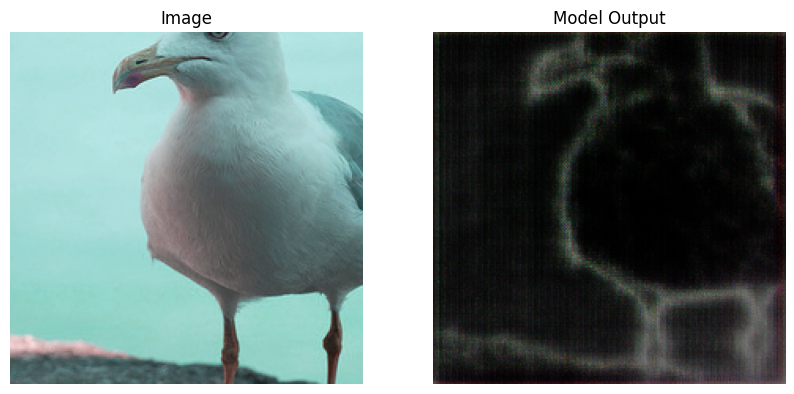

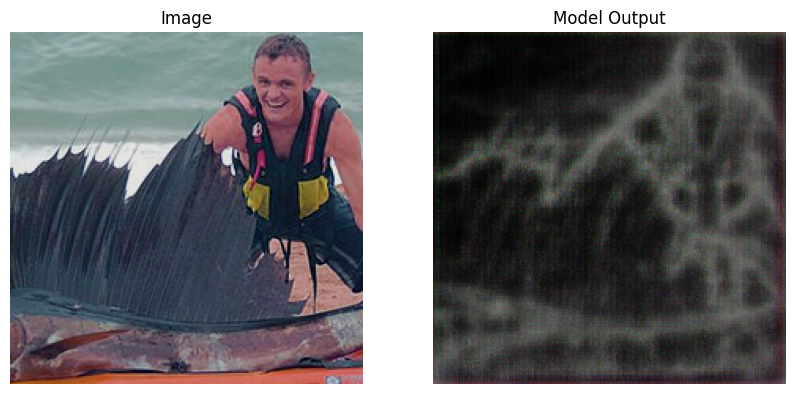

In [ ]:

model_path = dataroot+'best_model.pt'


model = torch.load(model_path)
generator = countour_detector(backbone=vgg16).to(device)
generator.load_state_dict(model)

def simple_predict(model):
    model.eval()

    dataset = GANDataset(dataroot, split='test', transform=train_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

    with torch.no_grad():
        for batch_idx, (real_samples, labels) in enumerate(dataloader):
            if batch_idx >1:
                break
            else:
                real_samples = real_samples.to(device)
                output = model(real_samples)

                real_samples=real_samples.cpu().detach().numpy()[0]
                output = output.cpu().detach().numpy()[0]
                label = labels.cpu().detach().numpy()[0]
                
                # Plot the output image and label using matplotlib
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
                ax1.axis("off")
                ax1.set_title("Image")
                ax1.imshow(real_samples.transpose((1, 2, 0)))

                ax2.axis("off")
                ax2.set_title("Model Output")
                ax2.imshow(output.transpose((1, 2, 0)))

                # print(g_loss)
                plt.show()

                
simple_predict(generator)

In [ ]:
my_model = countour_detector(backbone=vgg16).to(device)
my_model.load_state_dict(torch.load(dataroot+'best_model.pt'))

               

def avg_test_loss(model):
    model.eval()
    test_loss = 0
    num_samples = 0
    
    dataset = GANDataset(dataroot, split='test', transform=train_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                             shuffle=True, num_workers=0)

    with torch.no_grad():
        for batch_idx, (real_samples, labels) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            labels = labels.to(device)
            output = model(real_samples)
            batch_loss = context_loss(output, labels)
            test_loss += batch_loss.item()
            num_samples += 1

    avg_loss = test_loss / num_samples
    return avg_loss

avg_test_loss(my_model)

0.39850896783173084